#  [Введение](#введение)

### 1. [Знакомство с данными](#paragraph1)

### 2. [Предобработка данных](#paragraph2)

### 3. [Анализ данных](#paragraph3)

### 4. [Проверка гипотез](#paragraph4)

### 5. [Общий вывод](#paragraph5)

<a name="введение"></a>
# Определение перспективного тарифа для телеком компании
### Цель проекта:
Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

<a name="paragraph1"></a>
### Шаг 1 Откроем файлы с данными и изучим их

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import math
import warnings
warnings.filterwarnings("ignore")

In [2]:
calls = pd.read_csv('https://code.s3.yandex.net/datasets/calls.csv', sep=',')
internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet.csv', sep=',')
messages = pd.read_csv('https://code.s3.yandex.net/datasets/messages.csv', sep=',')
tariffs = pd.read_csv('https://code.s3.yandex.net/datasets/tariffs.csv', sep=',')
users = pd.read_csv('https://code.s3.yandex.net/datasets/users.csv', sep=',')

    Подробнее взглянем на каждую из таблиц, проверим нет ли дубликатов.

In [3]:
calls.head()
#calls.info() # пропусков нет

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
calls['id'].value_counts().sort_values(ascending=False)

1346_421    1
1303_46     1
1429_157    1
1251_327    1
1203_157    1
           ..
1142_226    1
1203_537    1
1110_182    1
1157_90     1
1460_520    1
Name: id, Length: 202607, dtype: int64

    Каждому звонку соответствует свой уникальный ид

In [5]:
calls['duration'].value_counts().sort_values(ascending=False)

0.00     39613
4.49       142
5.50       142
6.15       141
6.38       141
         ...  
29.33        1
27.65        1
30.58        1
26.93        1
24.28        1
Name: duration, Length: 2871, dtype: int64

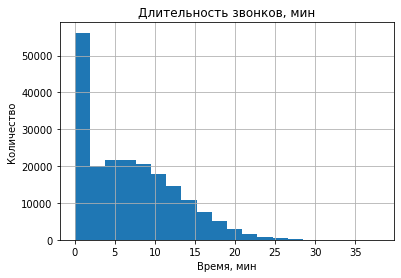

In [6]:
calls.hist('duration', bins=20)
plt.title('Длительность звонков, мин')
plt.xlabel('Время, мин')
plt.ylabel('Количество')
plt.show()

    Есть пик на на нуле. Округление идет в большую сторону - даже если звонок длился 5сек - засчитывается минута.
    Скорее всего это пропущенные звонки. 
    На данном этапе выбросов не видно - звонки свыше 20 мин вполне реальны, мы видим что 
    таких немного

In [7]:
print(calls['call_date'].nunique())
print(calls['user_id'].nunique())

365
492


    Все верно. 365 дней.
    Уникальниые пользователи - таких 492. Нам говорили о 500. 8 пользователей вообще не 
    делали звонков. Возможно, номер изменился. Потом посмотрим по другим таблицам. 

In [8]:
internet.head()
# internet.info() ## пропусков нет

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


    Столбец 'Unnamed:0' уберем чуть позже

In [9]:
internet['id'].value_counts().sort_values(ascending=False)

1483_36     1
1475_238    1
1303_46     1
1489_124    1
1203_157    1
           ..
1243_218    1
1378_366    1
1410_38     1
1376_326    1
1462_10     1
Name: id, Length: 149396, dtype: int64

    Каждой сессии соответсвует свой идентификатор. 

[[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbcec7909d0>]]


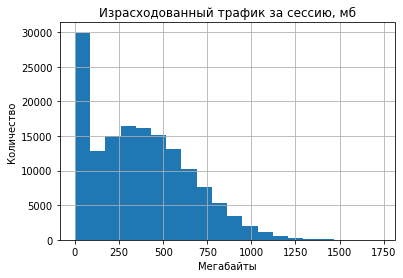

Количество нулевых интернет-сессий: 19598


In [10]:
print(internet.hist('mb_used', bins=20))
plt.title('Израсходованный трафик за сессию, мб')
plt.xlabel('Мегабайты')
plt.ylabel('Количество')
plt.show()
print('Количество нулевых интернет-сессий:', len(internet.query('mb_used == 0')))

    19598 из 149396 сессий имеют 0 в колонке мб. В остальном значения выглядит нормальными. Аномалий на первый взгляд не видно.

In [11]:
internet['session_date'].nunique()

365

    Здесь тоже все хорошо

In [12]:
internet['user_id'].nunique()

497

    Здесь уже 3 неактивных в течение года пользователя

In [13]:
messages.head()
#messages.info() ## пропусков нет

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [14]:
messages['id'].value_counts().sort_values(ascending=False)

1483_36     1
1423_207    1
1015_122    1
1482_503    1
1161_20     1
           ..
1436_173    1
1393_170    1
1209_351    1
1155_374    1
1404_1      1
Name: id, Length: 123036, dtype: int64

    Каждому сообщению присвоен свой уникальный id

In [15]:
print(messages['message_date'].nunique())
print(messages.duplicated().value_counts())

364
False    123036
dtype: int64


    Здесь данные по 364 дням. Один день выпал. Может это сбой на стороне оператора. 
    Дубликатов нет

In [16]:
messages['user_id'].nunique()

426

        Здесь уже больше неактивных пользователей. В целом можно допустить, что пользователи
        предпочитают больше общаться через мессенджеры, чем напрямую использовать такую 
        опцию в телефоне. 

In [17]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


    Здесь все понятно

In [18]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [19]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


    Пропуски только в столбце churn_date. Это логично. Пропуски означают, что клиент 
    перестал пользоваться тарифом. Таких 38

In [20]:
users['user_id'].nunique() ## все ок

500

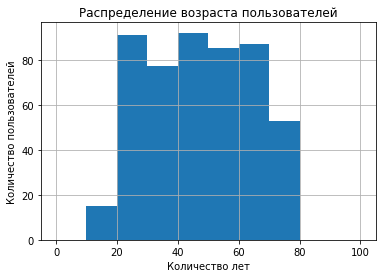

In [21]:
users.hist('age', bins=10, range=(0,100))
plt.title('Распределение возраста пользователей')
plt.xlabel('Количество лет')
plt.ylabel('Количество пользователей')
plt.show()

    Распределение выглядит нормальным. 

In [22]:
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

In [23]:
users['city'].value_counts()

Москва             99
Санкт-Петербург    39
Новосибирск        16
Омск               14
Казань             14
                   ..
Химки               1
Нижневартовск       1
Иваново             1
Подольск            1
Архангельск         1
Name: city, Length: 76, dtype: int64

### Вывод:
Итак, в целом данные выглядят нормально. На первый взгляд аномальных значений в столбцах 
не выявлено. 349 человек используют тариф **smart**, 149 - тариф **ultra**. Больше всего
пользователей приходятся на **Москву** и **Санкт-Петербург**
    

<a name="paragraph2"></a>
### Шаг 2 Предобработка и подготовка данных

    Приведем данные к нужному типу. Мегабайты и минуты округлим вверх и приведем к типу
    int

In [24]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')

In [25]:
def to_ceil(df, column):
    df[column] = np.ceil(df[column]).astype(int)

to_ceil(calls, 'duration')
to_ceil(internet, 'mb_used')

    Выделим месяц отдельно

In [26]:
def add_month(df, column):
    df['month'] = df[column].dt.month
    
add_month(calls, 'call_date')
add_month(internet, 'session_date')
add_month(messages, 'message_date')
add_month(users, 'reg_date')

    Посмотрим сколько нулевых звонков по отношению к общему числу

In [27]:
print('Процент нулевых звонков: {:.2%}'.format(len(calls[calls['duration'] == 0]) / len(calls)))

Процент нулевых звонков: 19.55%


    Уберем нулевые звонки. Посмотрим, изменилось ли количество пользователей

In [28]:
not_null_calls = calls.query('duration != 0')
print('Количество пользователей до выброса нулевых звонков:', not_null_calls['user_id'].nunique())
print('Количество пользователей после выброса нулевых звонков:', calls['user_id'].nunique())

Количество пользователей до выброса нулевых звонков: 492
Количество пользователей после выброса нулевых звонков: 492


    Посчитаем для каждого пользователя количество сделанных звонков и израсходованных минут
    разговора по месяцам

In [89]:
calls_count = calls.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')

In [90]:
calls_count.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3174 entries, (1000, 5) to (1499, 12)
Data columns (total 1 columns):
id    3174 non-null int64
dtypes: int64(1)
memory usage: 38.1 KB


In [91]:
calls_duration = calls.pivot_table(index=['user_id', 'month'], values='duration', 
                                   aggfunc='sum')

In [32]:
calls_duration.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3174 entries, (1000, 5) to (1499, 12)
Data columns (total 1 columns):
duration    3174 non-null int64
dtypes: int64(1)
memory usage: 38.1 KB


In [33]:
grouped_calls = calls_count.merge(calls_duration, on=['user_id', 'month']).reset_index()
grouped_calls = grouped_calls.rename(columns={'id': 'calls_by_month'})

In [34]:
print(grouped_calls.head())
print()
print('Длина датафрейма:', len(grouped_calls))

   user_id  month  calls_by_month  duration
0     1000      5              22       159
1     1000      6              43       172
2     1000      7              47       340
3     1000      8              52       408
4     1000      9              58       466

Длина датафрейма: 3174


In [35]:
#grouped_calls = grouped_calls.set_index('user_id')

    Посчитаем количество отправленных сообщений по месяцам

In [36]:
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [37]:
messages_count = messages.pivot_table(index=['user_id', 'month'], values='id', 
                                      aggfunc='count').reset_index()
messages_count = messages_count.rename(columns={'id': 'messages_by_month'})

In [38]:
messages_count.head()

,user_id,month,messages_by_month
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


    Посчитаем объем израсходованного интернет-трафика по месяцам

In [39]:
print(internet.head())
len(internet)

   Unnamed: 0      id  mb_used session_date  user_id  month
0           0  1000_0      113   2018-11-25     1000     11
1           1  1000_1     1053   2018-09-07     1000      9
2           2  1000_2     1198   2018-06-25     1000      6
3           3  1000_3      551   2018-08-22     1000      8
4           4  1000_4      303   2018-09-24     1000      9


149396

In [40]:
## уберем ненужный столбец
internet = internet.drop('Unnamed: 0', axis=1)
len(internet) ## данные не потерялись

149396

In [41]:
used_mb_count = internet.pivot_table(index=['user_id', 'month'], values='mb_used', 
                                      aggfunc='sum').reset_index()
used_mb_count = used_mb_count.rename(columns={'mb_used': 'mb_used_by_month'})

In [42]:
used_mb_count.head()

,user_id,month,mb_used_by_month
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,14581


    Посчитаем помесячную выручку с каждого пользователя.
    Начнем с объединения всех таблиц

In [43]:
df = grouped_calls.merge(messages_count, on=['user_id', 'month'], how='outer')
df.head()

,user_id,month,calls_by_month,duration,messages_by_month
0,1000,5,22.0,159.0,22.0
1,1000,6,43.0,172.0,60.0
2,1000,7,47.0,340.0,75.0
3,1000,8,52.0,408.0,81.0
4,1000,9,58.0,466.0,57.0


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3213 entries, 0 to 3212
Data columns (total 5 columns):
user_id              3213 non-null int64
month                3213 non-null int64
calls_by_month       3174 non-null float64
duration             3174 non-null float64
messages_by_month    2717 non-null float64
dtypes: float64(3), int64(2)
memory usage: 150.6 KB


In [45]:
df = df.merge(used_mb_count, on=['user_id', 'month'], how='outer')
df.head()

,user_id,month,calls_by_month,duration,messages_by_month,mb_used_by_month
0,1000,5,22.0,159.0,22.0,2256.0
1,1000,6,43.0,172.0,60.0,23257.0
2,1000,7,47.0,340.0,75.0,14016.0
3,1000,8,52.0,408.0,81.0,14070.0
4,1000,9,58.0,466.0,57.0,14581.0


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
user_id              3214 non-null int64
month                3214 non-null int64
calls_by_month       3174 non-null float64
duration             3174 non-null float64
messages_by_month    2717 non-null float64
mb_used_by_month     3203 non-null float64
dtypes: float64(4), int64(2)
memory usage: 175.8 KB


    Добавим колонку тариф, поменяем название некоторых столбцов

In [47]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,11
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,8
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5


In [48]:
df = df.merge(users, on='user_id', how='left')
df = df.rename(columns={'month_x': 'month', 'month_y': 'tariff_connect_month'})

In [49]:
df.head()

,user_id,month,calls_by_month,duration,messages_by_month,mb_used_by_month,age,churn_date,city,first_name,last_name,reg_date,tariff,tariff_connect_month
0,1000,5,22.0,159.0,22.0,2256.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
1,1000,6,43.0,172.0,60.0,23257.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
2,1000,7,47.0,340.0,75.0,14016.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
3,1000,8,52.0,408.0,81.0,14070.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
4,1000,9,58.0,466.0,57.0,14581.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5


    В некоторх строках у нас получились nanы. Такое могло произойти при группировке, когда
    пользователь в отдельно взятом месяце по какой-то причине не пользовался сообщениями/
    интернетом и тд. Поэтому эти пропуки лучше заменить 0, чтобы затем при расчете выручки
    избежать пропусков.
    

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 14 columns):
user_id                 3214 non-null int64
month                   3214 non-null int64
calls_by_month          3174 non-null float64
duration                3174 non-null float64
messages_by_month       2717 non-null float64
mb_used_by_month        3203 non-null float64
age                     3214 non-null int64
churn_date              187 non-null object
city                    3214 non-null object
first_name              3214 non-null object
last_name               3214 non-null object
reg_date                3214 non-null datetime64[ns]
tariff                  3214 non-null object
tariff_connect_month    3214 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(4), object(5)
memory usage: 376.6+ KB


In [51]:
fill_with_null = ['calls_by_month', 'duration', 'messages_by_month', 'mb_used_by_month']
for column in fill_with_null:
    df[column] = df[column].fillna(0)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 14 columns):
user_id                 3214 non-null int64
month                   3214 non-null int64
calls_by_month          3214 non-null float64
duration                3214 non-null float64
messages_by_month       3214 non-null float64
mb_used_by_month        3214 non-null float64
age                     3214 non-null int64
churn_date              187 non-null object
city                    3214 non-null object
first_name              3214 non-null object
last_name               3214 non-null object
reg_date                3214 non-null datetime64[ns]
tariff                  3214 non-null object
tariff_connect_month    3214 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(4), object(5)
memory usage: 376.6+ KB


    Напишем функцию для расчета выручки
   

In [53]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [54]:
def revenue(row):
    revenue = 0
    if row['tariff'] == 'smart':
        messages_remains = (row['messages_by_month'] - tariffs.loc[0]['messages_included'])
        if messages_remains > 0:
            revenue += messages_remains * 3
        duration_remains = (row['duration'] - tariffs.loc[0]['minutes_included'])
        if duration_remains > 0:
            revenue += duration_remains * 3
        mb_remains = (row['mb_used_by_month'] - tariffs.loc[0]['mb_per_month_included'])
        if mb_remains > 0:
            revenue += (mb_remains / 1000) * 200
        if revenue > 0:
            revenue += 550
        else:
            revenue = 550
            
    else:
        messages_remains = (row['messages_by_month'] - tariffs.loc[1]['messages_included'])
        if messages_remains > 0:
            revenue += messages_remains * 1
        duration_remains = (row['duration'] - tariffs.loc[1]['minutes_included'])
        if duration_remains > 0:
            revenue += duration_remains * 1
        mb_remains = (row['mb_used_by_month'] - tariffs.loc[1]['mb_per_month_included'])
        if mb_remains > 0:
            revenue += (mb_remains / 1000) * 150
        if revenue > 0:
            revenue += 1950
        else:
            revenue = 1950
    return revenue



In [55]:
df['revenue'] = df.apply(revenue, axis=1)

In [56]:
df.head()

,user_id,month,calls_by_month,duration,messages_by_month,mb_used_by_month,age,churn_date,city,first_name,last_name,reg_date,tariff,tariff_connect_month,revenue
0,1000,5,22.0,159.0,22.0,2256.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1950.0
1,1000,6,43.0,172.0,60.0,23257.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1950.0
2,1000,7,47.0,340.0,75.0,14016.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1950.0
3,1000,8,52.0,408.0,81.0,14070.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1950.0
4,1000,9,58.0,466.0,57.0,14581.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1950.0


    Посмотрим сколько раз пользователи приносили доход сверх абонетской платы

In [57]:
print('Кол-во раз, тариф smart:')
print(len(df.query('tariff == "smart" and revenue > 550')))
print('Кол-во раз, тариф ultra')
print(len(df.query('tariff == "ultra" and revenue > 1950')))

Кол-во раз, тариф smart:
1665
Кол-во раз, тариф ultra
134


### Вывод:
На этом этапе мы округлили некоторые признаки вверх, как это делает оператор. Убрали нулевые
звонки - они в расчет не идут. При этом количество пользователей не уменьшилось. Выделили месяц как отдельный столбец. Сделали сводные таблицы для подсчета общих значений по минутам, сообщениям, интернет трафику за месяц. Затем собрали в общую таблицу, сгруппировав по пользователю и месяцу. То есть, привели данные к виду, в котором они удобны и пригодны для анализа. Анализу посвящен третий раздел.

<a name="paragraph3"></a>
### Шаг 3 Анализируем данные

    Посмотрим средние значения звонков, сообщений, минут разговора и использованных мб
    в месяц

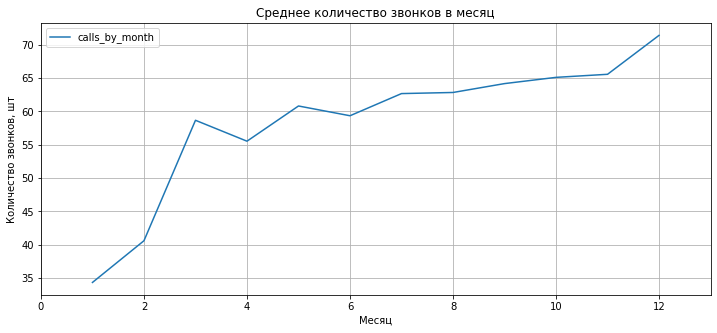

In [58]:
df.pivot_table(index='month', 
               values='calls_by_month',
              aggfunc='mean').plot(xlim=(0,13), grid=True, figsize=(12,5))
plt.title('Среднее количество звонков в месяц')
plt.ylabel('Количество звонков, шт')
plt.xlabel('Месяц')
plt.show()

    Количество звонков в среднем от месяца к месяцу растет. Здесь и дальше где это
    прослеживается такую динамику можно объяснить тем, что пользователь постепенно
    чувствует все меньше ограничений, видя запас бесплатного лимита тарифа.

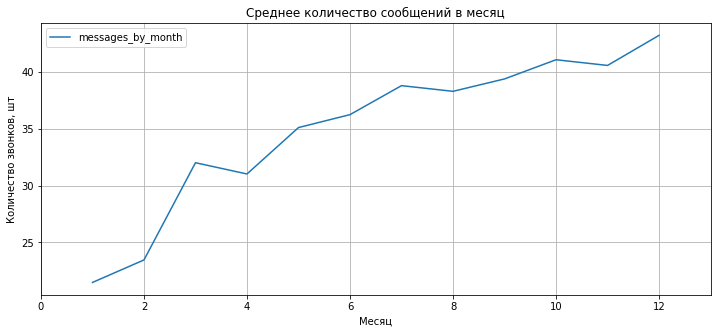

In [59]:
df.pivot_table(index='month', 
               values='messages_by_month',
              aggfunc='mean').plot(xlim=(0,13), grid=True, figsize=(12,5))
plt.title('Среднее количество сообщений в месяц')
plt.ylabel('Количество звонков, шт')
plt.xlabel('Месяц')
plt.show()

    Тоже самое и с сообщениями - в среднем их количество растет от месяца к месяцу

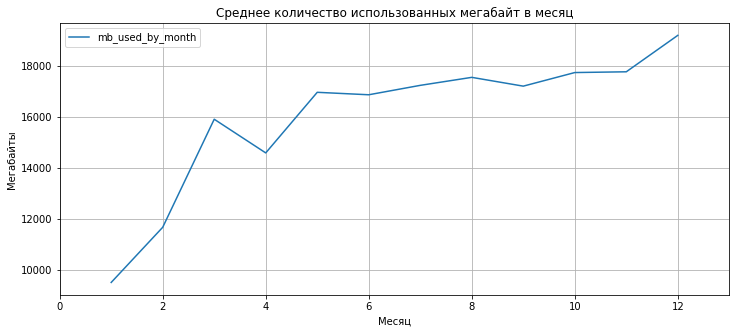

In [60]:
df.pivot_table(index='month', 
               values='mb_used_by_month',
              aggfunc='mean').plot(xlim=(0,13), grid=True, figsize=(12,5))
plt.title('Среднее количество использованных мегабайт в месяц')
plt.ylabel('Мегабайты')
plt.xlabel('Месяц')
plt.show()

    Аналогичная ситуация и здесь, посмотрим еще длительность звонков

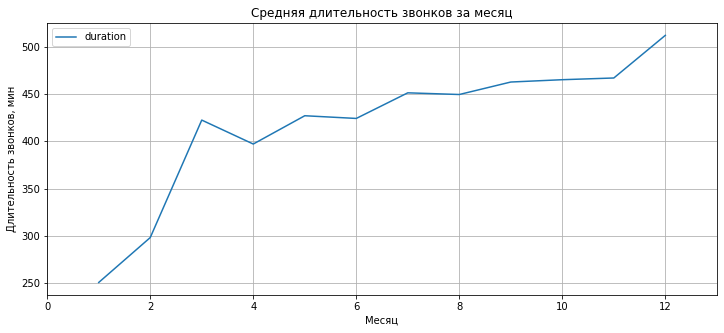

In [61]:
df.pivot_table(index='month', 
               values='duration',
              aggfunc='mean').plot(xlim=(0,13), grid=True, figsize=(12,5))
plt.title('Средняя длительность звонков за месяц')
plt.ylabel('Длительность звонков, мин')
plt.xlabel('Месяц')
plt.show()

    Та же картина и здесь.
    Далее посчитаем уже общее количество тех же характеристик за месяц

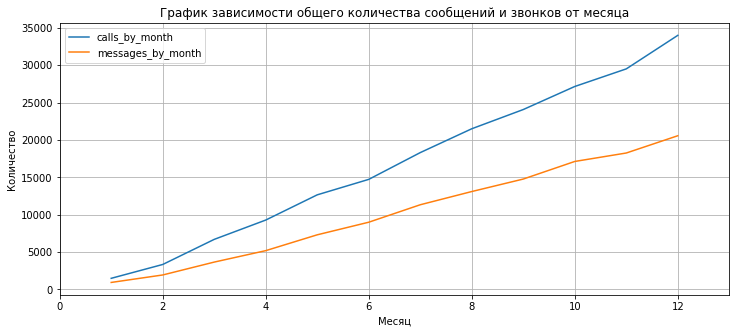

In [62]:
df.pivot_table(index='month', 
               values=['calls_by_month', 'messages_by_month'],
               aggfunc='sum').plot(xlim=(0,13), grid=True, figsize=(12,5))
plt.title('График зависимости общего количества сообщений и звонков от месяца')
plt.ylabel('Количество')
plt.xlabel('Месяц')
plt.show()

    Сделаем то же самое для количества использованных мегабайт

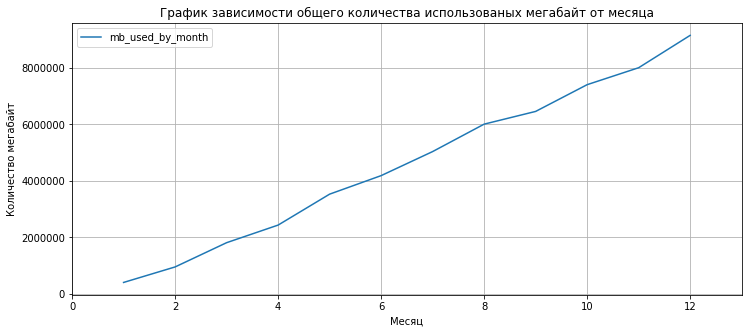

In [63]:
df.pivot_table(index='month', 
               values='mb_used_by_month',
               aggfunc='sum').plot(xlim=(0,13), grid=True, figsize=(12,5))
plt.title('График зависимости общего количества использованых мегабайт от месяца')
plt.ylabel('Количество мегабайт')
plt.xlabel('Месяц')
plt.show()

    Теперь посмотрм как меняется количество минут разговора от месяца

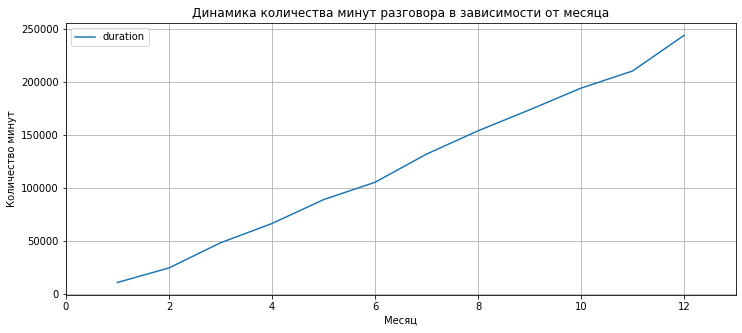

In [64]:
df.pivot_table(index='month', 
               values='duration',
               aggfunc='sum').plot(xlim=(0,13), grid=True, figsize=(12,5))
plt.title('Динамика количества минут разговора в зависимости от месяца')
plt.ylabel('Количество минут')
plt.xlabel('Месяц')
plt.show()

    Здесь тоже прослеживается такая же динамика. Месяц к месяцу количество проговоренных
    пользователем минут растет.
    
    Теперь разделим выборку на две группы по признаку 'tariff'. Найдем дисперсию и
    стандартное отклонение для каждого месяца

In [65]:
df_ultra = df.query('tariff == "ultra"')
df_smart = df.query('tariff == "smart"')

In [66]:
print('Количество пользователей с тарифом ultra:', df_ultra['user_id'].nunique())
print('Количество пользователей с тарифом smart:', df_smart['user_id'].nunique())

Количество пользователей с тарифом ultra: 148
Количество пользователей с тарифом smart: 350


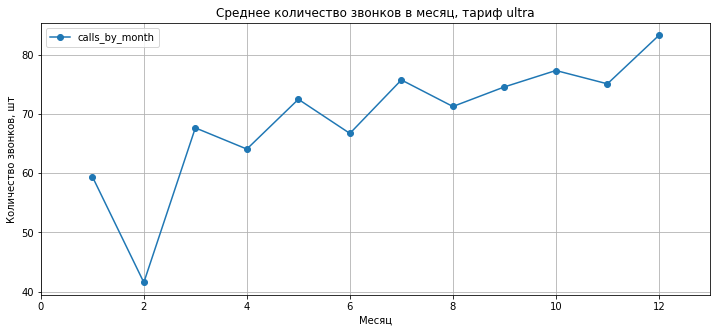

In [67]:
df_ultra.pivot_table(index='month', 
               values='calls_by_month',
              aggfunc='mean').plot(xlim=(0,13), grid=True, figsize=(12,5), style='o-')
plt.title('Среднее количество звонков в месяц, тариф ultra')
plt.ylabel('Количество звонков, шт')
plt.xlabel('Месяц')
plt.show()

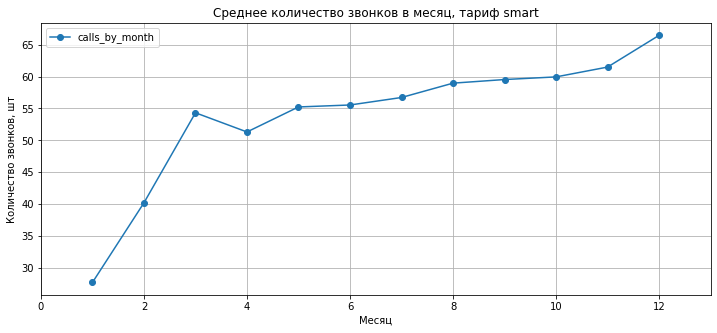

In [68]:
df_smart.pivot_table(index='month', 
               values='calls_by_month',
              aggfunc='mean').plot(xlim=(0,13), grid=True, figsize=(12,5), style='o-')
plt.title('Среднее количество звонков в месяц, тариф smart')
plt.ylabel('Количество звонков, шт')
plt.xlabel('Месяц')
plt.show()

    У пользователей тарифа smart более плавный рост количества звонков.

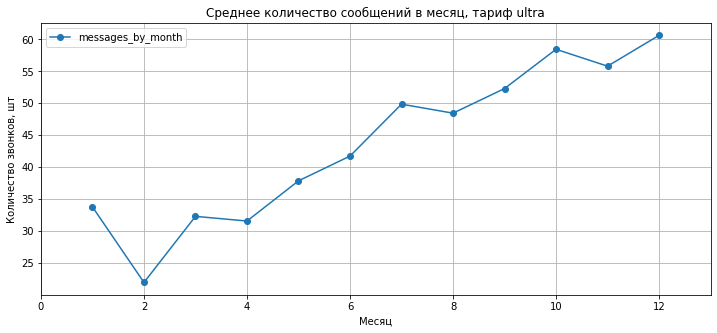

In [69]:
df_ultra.pivot_table(index='month', 
               values='messages_by_month',
              aggfunc='mean').plot(xlim=(0,13), grid=True, figsize=(12,5), style=('o-'))
plt.title('Среднее количество сообщений в месяц, тариф ultra')
plt.ylabel('Количество звонков, шт')
plt.xlabel('Месяц')
plt.show()

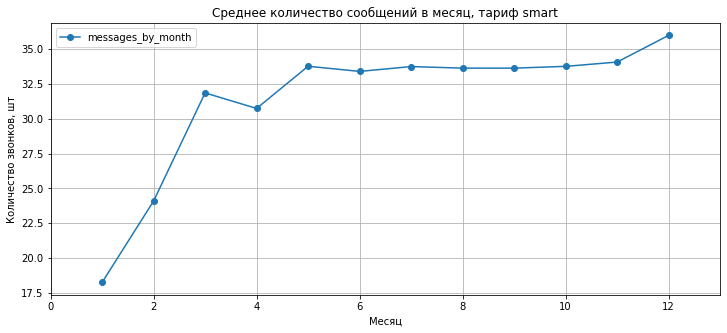

In [70]:
df_smart.pivot_table(index='month', 
               values='messages_by_month',
              aggfunc='mean').plot(xlim=(0,13), grid=True, figsize=(12,5), style='o-')
plt.title('Среднее количество сообщений в месяц, тариф smart')
plt.ylabel('Количество звонков, шт')
plt.xlabel('Месяц')
plt.show()

    Здесь тоже виден более плавный рост сообщений у пользователей тарифа smart. 
    Два последних графика для пользователей тарифа smart показывают спад во втором месяце

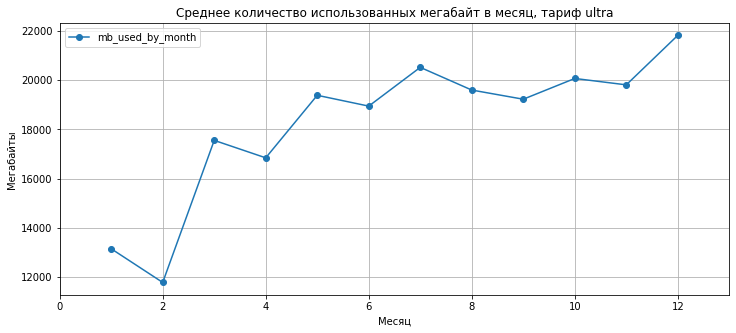

In [71]:
df_ultra.pivot_table(index='month', 
               values='mb_used_by_month',
              aggfunc='mean').plot(xlim=(0,13), grid=True, figsize=(12,5), style='o-')
plt.title('Среднее количество использованных мегабайт в месяц, тариф ultra')
plt.ylabel('Мегабайты')
plt.xlabel('Месяц')
plt.show()

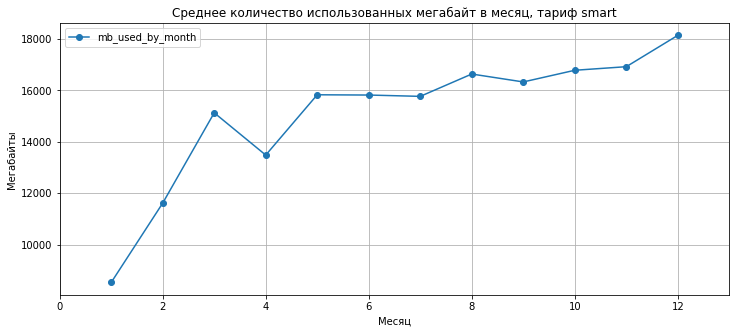

In [72]:
df_smart.pivot_table(index='month', 
               values='mb_used_by_month',
              aggfunc='mean').plot(xlim=(0,13), grid=True, figsize=(12,5), style='o-')
plt.title('Среднее количество использованных мегабайт в месяц, тариф smart')
plt.ylabel('Мегабайты')
plt.xlabel('Месяц')
plt.show()

    В целом здесь аналогичная ситуация, как и в случае с двумя признаками выше.
    Странным выглядит падение во втором месяце по тарифу ultra

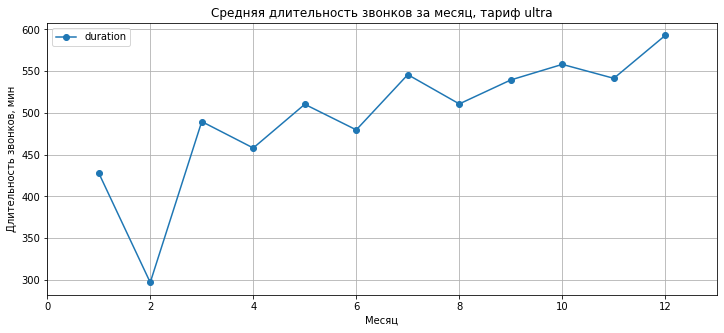

In [73]:
df_ultra.pivot_table(index='month', 
               values='duration',
              aggfunc='mean').plot(xlim=(0,13), grid=True, figsize=(12,5), style='o-')
plt.title('Средняя длительность звонков за месяц, тариф ultra')
plt.ylabel('Длительность звонков, мин')
plt.xlabel('Месяц')
plt.show()

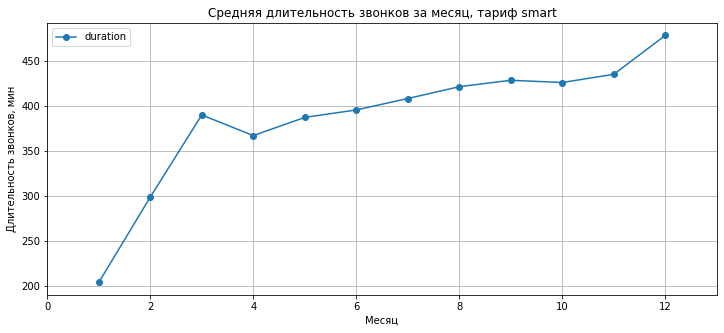

In [74]:
df_smart.pivot_table(index='month', 
               values='duration',
              aggfunc='mean').plot(xlim=(0,13), grid=True, figsize=(12,5), style='o-')
plt.title('Средняя длительность звонков за месяц, тариф smart')
plt.ylabel('Длительность звонков, мин')
plt.xlabel('Месяц')
plt.show()

    Графики снова похожи.

    Посмотрим дисперсию по трем главным характеристикам для каждого месяца для двух 
    тарифов. 

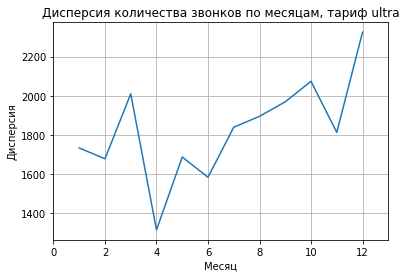

In [75]:
df_ultra.groupby('month')['calls_by_month'].var().plot(grid=True, xlim=(0,13))
plt.title('Дисперсия количества звонков по месяцам, тариф ultra')
plt.xlabel('Месяц')
plt.ylabel('Дисперсия')
plt.show()

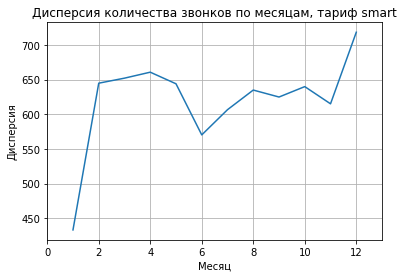

In [76]:
df_smart.groupby('month')['calls_by_month'].var().plot(grid=True, xlim=(0,13))
plt.title('Дисперсия количества звонков по месяцам, тариф smart')
plt.xlabel('Месяц')
plt.ylabel('Дисперсия')
plt.show()

    По тарифу smart дисперсия в два раза ниже, чем по тарифу ultra. Возможно, это
    объясняется тем, что выборка тарифа smart в два раза больше.

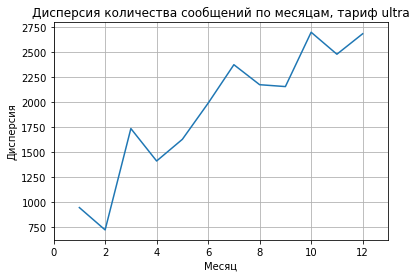

In [77]:
df_ultra.groupby('month')['messages_by_month'].var().plot(grid=True, xlim=(0,13))
plt.title('Дисперсия количества сообщений по месяцам, тариф ultra')
plt.xlabel('Месяц')
plt.ylabel('Дисперсия')
plt.show()

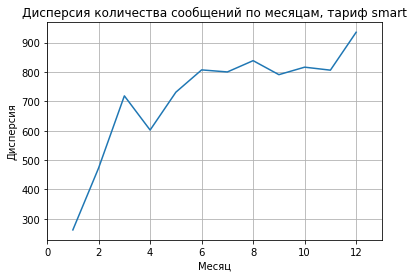

In [78]:
df_smart.groupby('month')['messages_by_month'].var().plot(grid=True, xlim=(0,13))
plt.title('Дисперсия количества сообщений по месяцам, тариф smart')
plt.xlabel('Месяц')
plt.ylabel('Дисперсия')
plt.show()

    Здесь происходит то же самое - дисперсия по выборке ultra выше более чем в два раза

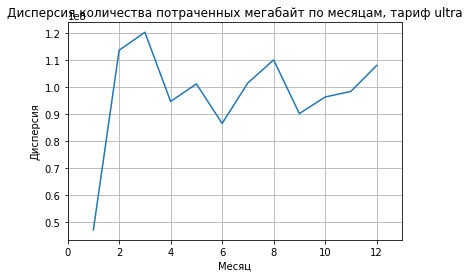

In [79]:
df_ultra.groupby('month')['mb_used_by_month'].var().plot(grid=True, xlim=(0,13))
plt.title('Дисперсия количества потраченных мегабайт по месяцам, тариф ultra')
plt.xlabel('Месяц')
plt.ylabel('Дисперсия')
plt.show()

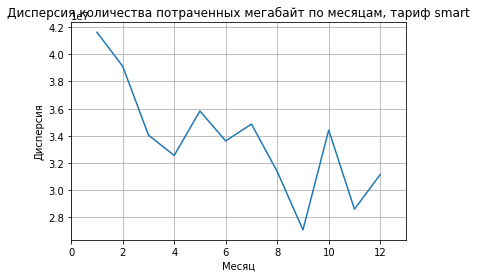

In [80]:
df_smart.groupby('month')['mb_used_by_month'].var().plot(grid=True, xlim=(0,13))
plt.title('Дисперсия количества потраченных мегабайт по месяцам, тариф smart')
plt.xlabel('Месяц')
plt.ylabel('Дисперсия')
plt.show()

    У тарифа smart дисперсия выше, виден нисходящий тренд.
    Теперь сделаем графики стандартного отклонения. Зная дисперсию, можно предположить,
    что результаты будут похожими. 

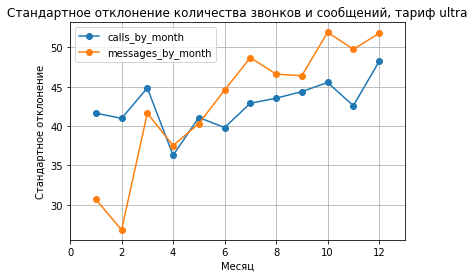

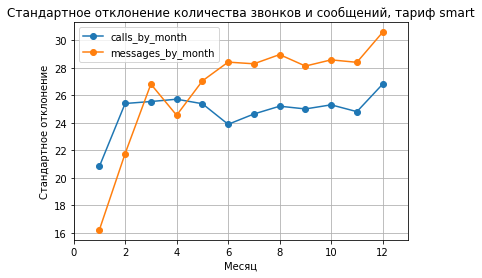

In [81]:
df_ultra.pivot_table(index='month', 
                     values=['calls_by_month', 'messages_by_month'],
                     aggfunc=np.std).plot(grid=True, xlim=(0,13), style='o-')
plt.title('Стандартное отклонение количества звонков и сообщений, тариф ultra')
plt.xlabel('Месяц')
plt.ylabel('Стандартное отклонение')
plt.show()

df_smart.pivot_table(index='month', 
                     values=['calls_by_month', 'messages_by_month'],
                     aggfunc=np.std).plot(grid=True, xlim=(0,13), style='o-')
plt.title('Стандартное отклонение количества звонков и сообщений, тариф smart')
plt.xlabel('Месяц')
plt.ylabel('Стандартное отклонение')
plt.show()

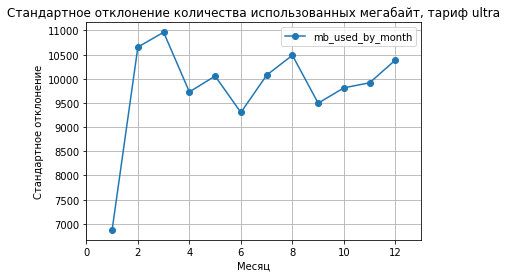

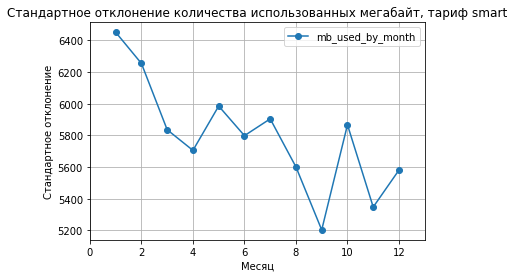

In [82]:
df_ultra.pivot_table(index='month', 
                     values='mb_used_by_month',
                     aggfunc=np.std).plot(grid=True, xlim=(0,13), style='o-')
plt.title('Стандартное отклонение количества использованных мегабайт, тариф ultra')
plt.xlabel('Месяц')
plt.ylabel('Стандартное отклонение')
plt.show()

df_smart.pivot_table(index='month', 
                     values='mb_used_by_month',
                     aggfunc=np.std).plot(grid=True, xlim=(0,13), style='o-')
plt.title('Стандартное отклонение количества использованных мегабайт, тариф smart')
plt.xlabel('Месяц')
plt.ylabel('Стандартное отклонение')
plt.show()

    Как и было сказано ранее, стандартное отклонение между двумя тарифами имеет похожее
    различие, что и дисперсия этих тарифов, так как является квадратным корнем из нее.

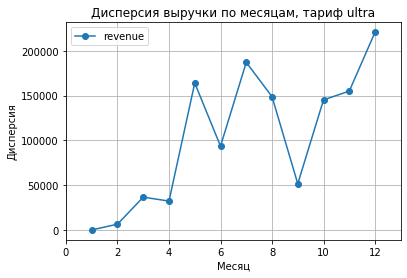

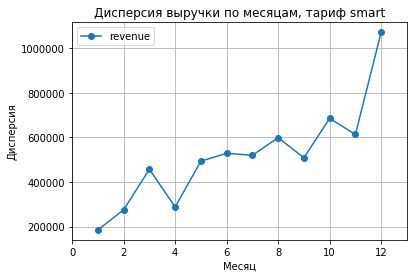

In [83]:
df_ultra.pivot_table(index='month', 
                     values='revenue',
                     aggfunc=np.var).plot(grid=True, xlim=(0,13), style='o-')
plt.title('Дисперсия выручки по месяцам, тариф ultra')
plt.xlabel('Месяц')
plt.ylabel('Дисперсия')
plt.show()

df_smart.pivot_table(index='month', 
                     values='revenue',
                     aggfunc=np.var).plot(grid=True, xlim=(0,13), style='o-')
plt.title('Дисперсия выручки по месяцам, тариф smart')
plt.xlabel('Месяц')
plt.ylabel('Дисперсия')
plt.show()

    Дисперсия имеет схожую динамику по обоим выборкам: растет от месяца к месяцу, правда
    у пользователей тарифа ultra имеет зигзагооборазную форму.
    Тариф smart имеет дисперсию в несколько раз выше, чем у тарифа ultra

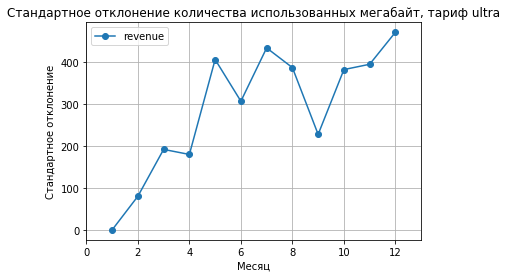

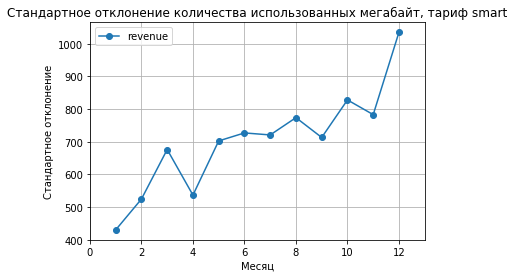

In [84]:
df_ultra.pivot_table(index='month', 
                     values='revenue',
                     aggfunc=np.std).plot(grid=True, xlim=(0,13), style='o-')
plt.title('Стандартное отклонение количества использованных мегабайт, тариф ultra')
plt.xlabel('Месяц')
plt.ylabel('Стандартное отклонение')
plt.show()

df_smart.pivot_table(index='month', 
                     values='revenue',
                     aggfunc=np.std).plot(grid=True, xlim=(0,13), style='o-')
plt.title('Стандартное отклонение количества использованных мегабайт, тариф smart')
plt.xlabel('Месяц')
plt.ylabel('Стандартное отклонение')
plt.show()

    Ситуация аналогичная, так как стандартное отклонение есть корень из дисперсии

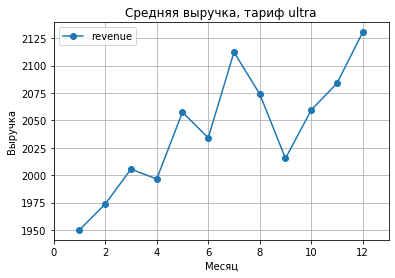

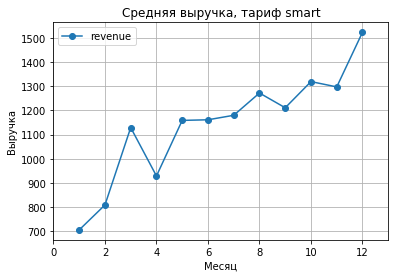

In [85]:
df_ultra.pivot_table(index='month', 
                     values='revenue',
                     aggfunc='mean').plot(grid=True, xlim=(0,13), style='o-')
plt.title('Средняя выручка, тариф ultra')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.show()

df_smart.pivot_table(index='month', 
                     values='revenue',
                     aggfunc='mean').plot(grid=True, xlim=(0,13), style='o-')
plt.title('Средняя выручка, тариф smart')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.show()

    Выручка по обоим группам растет. Заметен пик в декабре. У тарифа ultra есть спад в 
    апреле, июне и сентябре, у тарифа smart - небольшой спад в апреле, июне и ноябре.

### Вывод:
Мы посмотрели средние значения звонков, сообщений, потраченных мегабайт от месяца к месяцу. Начиная с первого месяца и далее средние этих трех признаков растут - пользователь чувствует все меньше ограничений и старается максимально использовать бесплатный лимит своего тарифа. Далее мы создали два датафрейма - по одному на каждый тариф. Посчитали для них дисперсию и стандартное отклонение тех же трех характеристик. По тарифу smart дисперсия в два раза ниже, чем по тарифу ultra (объясняется разностью в объеме выборок), кроме признака mb_used_by_month - там дисперсия выше у тарифа smart, но и она снижается от первого месяца и до конца года.

При анализе выручки двух тарифов получили следующие результаты: **выручка** по обоим группам растет. Заметен пик в декабре. У тарифа ultra есть спад в апреле, июне и сентябре, у тарифа smart - небольшой спад в апреле, июне и ноябре. **Дисперсия** и **стандартное отклонение** имеет схожую динамику по обоим выборкам: растет от месяца к месяцу, правда у пользователей тарифа ultra имеет зигзагооборазную форму.

<a name="paragraph4"></a>
### Шаг 4 Проверка гипотез

    Нулевая гипотеза в обоих случаях предполагает, что средняя выручка двух выборок не
    различается.
    Зададим p value = 5%. Это вероятность получить наблюдаемый или ещё более далёкий от
    предполагаемого результат при условии, что нулевая гипотеза верна. То есть, если
    вероятность получить такой результат выше 5% мы не будем отвергать нулевую гипотезу.

In [86]:
from scipy import stats as st

In [87]:
## Проверяем, как распределены выборки
shapiro_test_ultra = st.shapiro(df_ultra['revenue'])
shapiro_test_smart = st.shapiro(df_smart['revenue'])
print('Результаты теста Шапиро, тариф ultra:', shapiro_test_ultra)
print('Результаты теста Шапиро, тариф smart:', shapiro_test_smart)

NameError: name 'stats' is not defined

    В обоих случаях p-value ниже 0.05, поэтому отклоняем нулевую гипотезу о нормальном
    распределении выброк. Значит, используем тест Левена.

In [ ]:
st.levene(df_ultra['revenue'], df_smart['revenue'], center='mean')

    p-value меньше заданного 0.05, значит выборки гетерогенны. В st.ttest_ind параметр
    equal_var=False

In [ ]:
alpha = 0.05
results = st.ttest_ind(
    df_ultra['revenue'],
    df_smart['revenue'],
    equal_var=False)

print('p-значение: ', results.pvalue) 
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

    Проверим гипотезу, что средняя выручка пользователей из Москвы отличается от выручки
    пользователей из других регионов. 
    Нулевая гипотеза - средняя выручка пользователей из Москвы не отличается от выручки
    пользователей из других регионов

    Проверим выборки на гомогенность, как и в примере выше

In [ ]:
## Проверяем, как распределены выборки
msc = df.query('city == "Москва"')
another_cities = df.query('city != "Москва"')
shapiro_test_msc = st.shapiro(msc['revenue'])
shapiro_test_another_cities = st.shapiro(another_cities['revenue'])
print('Результаты теста Шапиро, тариф ultra:', shapiro_test_msc)
print('Результаты теста Шапиро, тариф smart:', shapiro_test_another_cities)

    В обоих случаях p-value ниже 0.05, поэтому отклоняем нулевую гипотезу о нормальном
    распределении выброк. Значит, используем тест Левена.

In [ ]:
st.levene(df_ultra['revenue'], df_smart['revenue'], center='mean')

     p-value меньше заданного 0.05, значит выборки гетерогенны. В st.ttest_ind параметр
    equal_var=False

In [ ]:
alpha = 0.05
results = st.ttest_ind(
    msc['revenue'],
    another_cities['revenue'],
    equal_var=False)

print('p-значение: ', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

In [ ]:
print('Средняя выручка пользователей тарифа smart:', df_smart['revenue'].mean())
print('Средняя выручка пользователей тарифа ultra:', df_ultra['revenue'].mean())

    В среднем пользователи тарифа ultra приносят больше выручки. В какой-то степени это 
    можно объяснить повышенной ежемесячной платой.

### Вывод:
- Результат первой гипотезы о том, что средняя выручка пользователей тарифов smart и ultra различается: p-value = 6.419305524051446e-280, это меньше заданного уровня статистической значимости, поэтому отвергаем нулевую гипотезу. Значит, есть основания предполагать, что выручка двух выборок имеет статистическое различие.
- Результат второй гипотезы о том, что средняя выручка пользователей из Москвы и других регионов различается: p-value = 0.5061098431334738. Полученное значение p-value говорит о том, что хотя средняя выручка двух выборок неодинакова, с вероятностью в  почти 50% такое или большее различие можно получить случайно.

<a name="paragraph5"></a>
### Шаг 5 Общий вывод

Целью этого исследования было выяснить, какой из двух тарифов - smart или ultra приносит больше денег компании. 
Первым делом мы начали с изучения данных. Аномалий выявлено не было.

Затем мы привели данные к удобному для анализа виду. Для этого мы привели некоторые признаки к нужному виду (округление вверх), добавили новый признак - месяц, так как выручка в дальнейшем считали по этому признаку. Сгруппировали данные в одну таблицу, чтобы было удобнее сделать анализ.

На этапе анализа была выявлена закономерность - общее число звонок, их длительность, число сообщений, количество потраченных мегабайт росло от месяца к месяцу. Это объясняется тем, что пользователь привыкает к тарифу и старается использовать его по максимуму, в некоторых случаях платя даже сверх ежемесячной платы. Сверх ежемесячной платы чаще платят пользователи тарифа **smart** - 1665 раз. Пользователи тарифа **ultra** - 134 раза. Это объясняется разницей в ежемесячной плате, так как позже было выявлено, что пользователи тарифа **ultra** в среднем приносят большую выручку - 2063руб в месяц. Пользователи тарифа **smart** - 1246руб. в месяц. Поэтому можно сделать вывод о том, что тариф **ultra приносит больше денег компании**, если не брать во внимание количество подключенных пользователей к каждому из тарифов

Проверка гипотезы о том, что средняя выручка пользователей тарифов smart и ultra различается имеет p-value = 6.419305524051446e-280, это меньше заданного уровня статистической значимости, поэтому мы отвергаем нулевую гипотезу. Это значит, есть основания предполагать, что средняя выручка двух выборок имеет статистическое различие.

Вторая гипотеза о том, что средняя выручка пользователей из Москвы и других регионов различается имеет p-value = 0.5061098431334738. Полученное значение p-value говорит о том, что хотя средняя выручка двух выборок неодинакова, с вероятностью в  почти 50% такое или большее различие можно получить случайно.